In [89]:
# Imports
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline 

## Return Forecasting: Read Historical Daily Yen Futures Data
---

In [90]:
# Read in data and preview
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2,1
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1


In [91]:
# Trim Dataset to begin on Jan 1st 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head() 

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336,51473
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206,53860
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649,55699
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944,53111
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763,52072


## Return Forecasting: Initial Time-Series Plotting
---

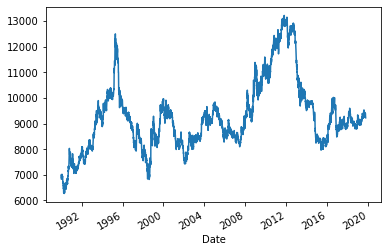

In [92]:
# Plot Settle column
yen_futures["Settle"].plot()

## Hodrick-Prescott Filter
---

In [93]:
# Import statsmodels.api
import statsmodels.api as sm

In [94]:
# Use the `hpfilter` function to decompose the Settle column into the trend and noise components.
yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])

In [95]:
# Create a dataframe of just the settle price and concat noise & trend
yen_df = yen_futures["Settle"]
yen_df = pd.concat([yen_df, yen_noise, yen_trend], axis="columns", join="inner")
# preview
yen_df.head()

,Settle,Settle_cycle,Settle_trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


In [99]:
# Rename columns and preview
columns = ["Settle", "Noise", "Trend"]
yen_df.columns = columns
yen_df.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


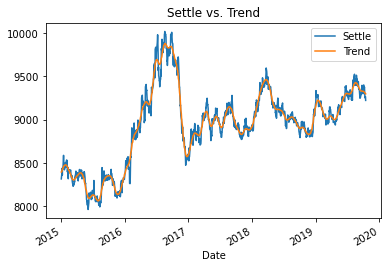

In [116]:
# Slice data from 2015 to present
yen_2015 = yen_df.loc["2015-01-01":, :]

# Drop Noise column
yen_2015 = yen_2015.drop(columns="Noise")

# Plot the Settle Price vs. Trend for 2015 to the Present
yen_2015.plot(title="Settle vs. Trend")

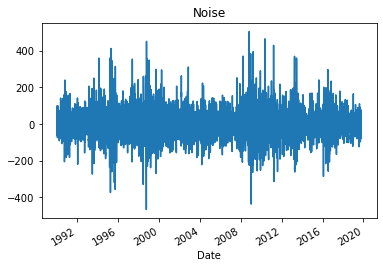

In [115]:
# Plot the Settle Noise
yen_noise.plot(title="Noise")

## ARMA
---

In [141]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [120]:
# import ARMA
from statsmodels.tsa.arima_model import ARMA

In [124]:
# Estimate ARMA model using statsmodels
model = ARMA(returns.values, order=(2, 1))

# Fit the model and assign to variable results
results = model.fit()

# Output summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Fri, 20 Nov 2020   AIC                          15798.142
Time:                        19:45:15   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3059      1.278     -0.239      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2944      1.278      0.230      0.818      -2.210       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3382           +0.0000j            3.3382            0.5000
AR.2         -157.3438           +0.0000j          157.3438            0.5000
MA.1           -3.3973           +0.0000j            3.3973            0.5000
-----------------------------------------------------------------------------
"""

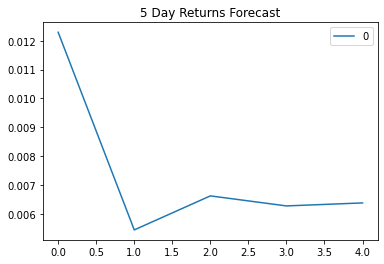

In [126]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

## ARIMA
---

In [136]:
# Import ARIMA
from statsmodels.tsa.arima_model import ARIMA

# Estimate an ARIMA Model to raw Yen Settle Data
model = ARIMA(yen_df.Settle.values, order=(5, 1, 1))

# Fit the model and assign to variable called results_arima
results_arima = model.fit()

In [137]:
# Output model summary results_arima
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Fri, 20 Nov 2020   AIC                          83905.238
Time:                        19:54:57   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3158      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.y      0.2814      0.699      0.402      0.688      -1.090       1.652
ar.L2.D.y      0.0007      0.016      0.042      0.966      -0.030       0.032
ar.L3.D.y     -0.0127      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.y     -0.0137      0.015     -0.890      0.374      -0.044       0.016
ar.L5.D.y     -0.0012      0.018     -0.066      0.948      -0.036       0.034
ma.L1.D.y     -0.2964      0.699     -0.424      0.672      -1.667       1.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8905           -1.3790j            2.3400           -0.1003
AR.2            1.8905           +1.3790j            2.3400            0.1003
AR.3           -2.2637           -3.0253j            3.7785           -0.3522
AR.4           -2.2637           +3.0253j            3.7785            0.3522
AR.5          -10.8643           -0.0000j           10.8643           -0.5000
MA.1            3.3740           +0.0000j            3.3740            0.0000
-----------------------------------------------------------------------------
"""

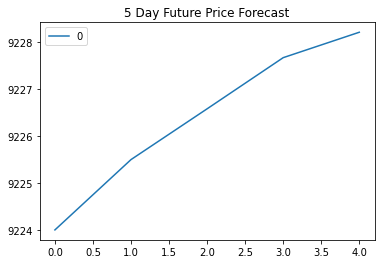

In [139]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(title="5 Day Future Price Forecast")

## GARCH
---

In [143]:
# Import arch
from arch import arch_model

In [151]:
# Estimate a GARCH model
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results = model.fit(disp="off")

In [152]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Fri, Nov 20 2020   Df Residuals:                     7510
Time:                        20:08:50   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [153]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [155]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)

In [157]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [158]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


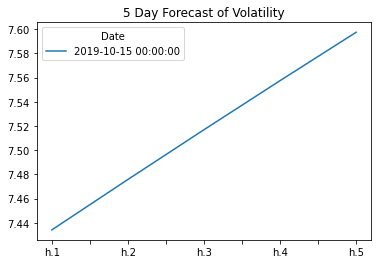

In [159]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")

## Conclusion
---

### Based on your time series analysis, would you buy the yen now?

Based on future forecasting, I would buy the yen but hold ST due to the increasing volatility.

### Is the risk of the yen expected to increase or decrease?

Similar to the above, based on future forecasting the yen is expected to increase.

### Based on the model evaluation, would you feel confident in using these models for trading?

I wouldn't feel confident about the model due to the high P-Score.